# Определение возраста покупателей по фотографии

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель исследования**

Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Задачи исследования**

- провести исследовательский анализ набора фотографий;
- подготовить данные к обучению;
- oбучить нейронную сеть и рассчитайте её качество;
- метрика качества - MAE.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.
В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Импорт используемых библиотек

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import pandas as pd

## Исследовательский анализ данных

### Загрузка данных

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Ознакомимся с данными:

In [ ]:
#универсальная функция для ознакомления с данными
def data_review(data):
    '''
    data - DataFrame

    '''
    print('*'*10, 'The Original DataFrame', '*'*10)
    display(data.head())
    print('')
    print('')
    print('*'*10, 'General Information', '*'*10)
    print('')
    data.info()
    print('')
    print('')
    print('*'*10, 'Has NaN', '*'*10)
    display(pd.DataFrame(data.isna().sum()).style.background_gradient('coolwarm'))
    print('*'*10, 'Has NaN Percentage', '*'*10)
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm'))
    print('')
    print('')
    print('*'*10, 'Descriptive Statistics', '*'*10)
    display(pd.DataFrame(data.describe()))

In [ ]:
data_review(labels)

********** The Original DataFrame **********


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17




********** General Information **********

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


********** Has NaN **********


,0
file_name,0
real_age,0


********** Has NaN Percentage **********


,0
file_name,0.000000
real_age,0.000000




********** Descriptive Statistics **********


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### График распределения возраста в выборке

Построим график распределения возраста в выборке:

In [ ]:
def num_to_scan(df, col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Histogram
    sns.histplot(df, x=col, bins=100, ax=axes[0])
    axes[0].set_title(col)

    # Boxplot
    df.boxplot(column=col, ax=axes[1])
    axes[1].set_ylabel(col)

    plt.show()
    display(pd.DataFrame(df[col].describe()))

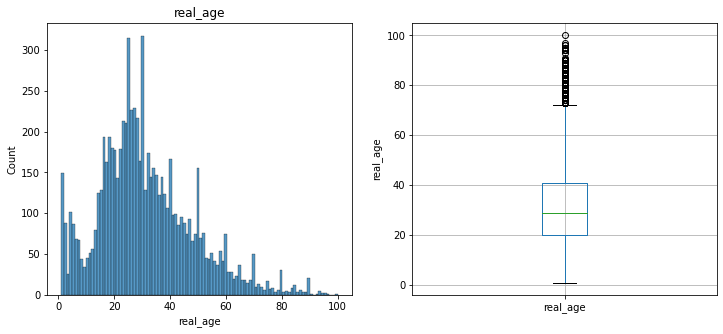

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
num_to_scan(labels, 'real_age')

In [ ]:
features, target = next(datagen_flow)

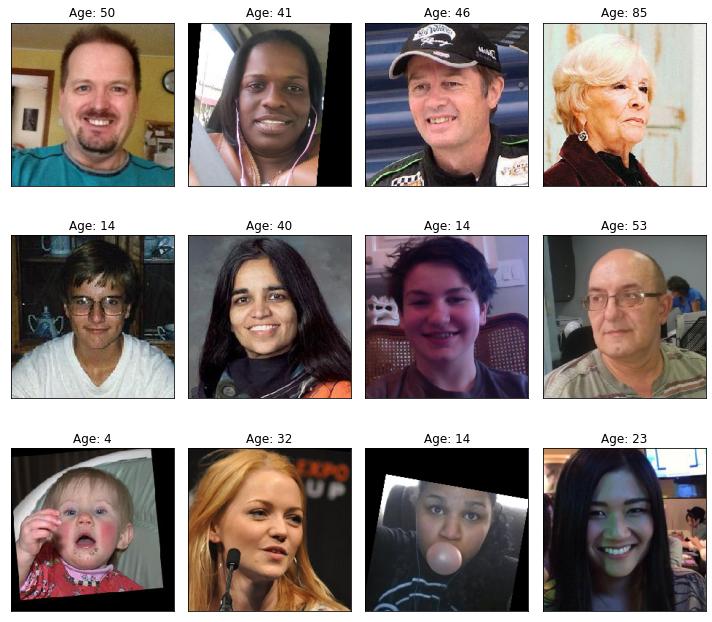

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(features[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Age: {target[i]}')
    plt.tight_layout()

### Выводы

- выборка содержить 7591 изображения;
- межквартильный размах представлен фотографиями людей от 20 до 41 года;
- фотографии людей в вострасте более 72 лет представлены минимально и определены ящикос с усами как выбросы;
- досточно большое количество фотографий людей представлено возрастом менее 10 лет;
- изображения входящие в датасет имеют ряд особенностей, а именно:
  - разнообразный фон фотографий;
  - наличие посторонних предметов и аксессуаров на лице;
  - часть фотографий повернута в профиль;
  - присутсвуют головные уборы;
  - лица выражают различные эмоции.

Исследовательский анализ данных показал, что представленный датасет имеет ряд недостатков для выполнения поставленных задач, так как недостаточно представлен фотографиями людей от 15 до 18, которые являются наиболее трудноопределимыми на достижение ими 18 летнего возраста. Однако это может быть компенсировано основным ядром фотографий людей в возрасте от 20 до 41 года. Для задачи анализа покупок данных достаточно. Также можно отметить большое количество фотографий людей возрастом до 10, которые не являются целевой группой ни для одной из задач.

Фотографии людей, входящих в датасет достаточно разнообразны в своем содержании, что может улучшить работу модели на реальных людях с определенными особенностями во внешнем виде в момент работы модели по определению возраста покупателя.


## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       rotation_range=30,
                                       validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)
      
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    optimizer = Adam(lr=0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 120s - loss: 261.7200 - mae: 11.5730 - val_loss: 701.1272 - val_mae: 21.5318

Epoch 2/10
178/178 - 90s - loss: 95.3058 - mae: 7.4332 - val_loss: 519.7805 - val_mae: 17.5603

Epoch 3/10
178/178 - 91s - loss: 71.8936 - mae: 6.4959 - val_loss: 272.9564 - val_mae: 12.2136

Epoch 4/10
178/178 - 91s - loss: 59.0054 - mae: 5.8943 - val_loss: 128.3038 - val_mae: 8.4968

Epoch 5/10
178/178 - 90s - loss: 54.3861 - mae: 5.6179 - val_loss: 130.8397 - val_mae: 8.6492

Epoch 6/10
178/178 - 90s - loss: 45.2468 - mae: 5.1476 - val_loss: 78.9738 - val_mae: 6.6893

Epoch 7/10
178/178 - 90s - loss: 35.8362 - mae: 4.6004 - val_loss: 84.8698 - val_mae: 6.8919

Epoch 8/10
178/178 - 90s - loss: 30.7359 - mae: 4.2638 - val_loss: 71.5784 - val_mae: 6.3294

Epoch 9/10
178/178 - 90s - loss: 25.9663 - mae: 3.9179 - val_loss: 68.3033 - val_mae: 6.0911

Epoch 10/10
178/178 - 90s - loss: 24.3898 - mae: 3.7901 - val_loss: 72.6862 - val_mae: 6.4058

60/60 - 9s - loss: 72.6862 - mae: 6.4058
Test MAE: 6.4058


```

## Анализ обученной модели

- Для обучения модели использована архитектура ResNet50. Предобученные веса backbone загружены с сервера.
- Top сети представлен 4 слоями:
  - 1 слой GlobalAveragePooling2D усредняющий информацию по всему изображению;
  - 2 полносвязных слоя: на 100 и 20 нейронов с активацией Relu;
  - 1 полносвязный слой для регрессии с активацией linear.
- В заморозке весов backbone необходимость отсутвует, размер датасета достаточен;
- Оптимизатор принят алгоритмом Adam, который быстрее всех находит минимум;
- Количество эпох 10 принято экспериментальным путем;
- Размер батча 32 принят экспериментальным путем.


- Обученная модель достигла требуемой заданием метрики MAE менее 8. Переобучение отсутсвует.
- Метрика МАЕ (средняя абсолютная ошибка) говорит нам о том, что модель в среднем ошибается на 6.5 лет. Это критично для определения возраста продажи алкоголя. Проверка паспорта продолжает быть актуальной и не может быть заменена на предсказания модели.
- Для рекомендаций товара для определенной возрастной группы данная модель может быть использована, так как в данном случае не требуется высокая точность предсказания.